In [20]:
library(vroom)
library(stringr)
library(dplyr)
library(tidyverse)
library(kableExtra)
library(plotly)
library(zoo)
library(ggthemes)
library(ggplot2)
library(gridExtra)
library(lubridate)
library(patchwork)
library(dplyr)
library(tidyr)

In [21]:
path = '/Users/stathis/Desktop/UVA_master/Forecasting/FinalProject/'

sell_prices <- vroom(str_c(path,"sell_prices_afcs2023.csv"), delim = ",", col_types = cols())

sales_train_validation <- vroom(str_c(path,"sales_train_validation_afcs2023.csv"), delim = ",", col_types = cols())

sales_train_validation_merged <- vroom(str_c(path,"merged_full_all.csv"), delim = ",", col_types = cols())

calendar <- vroom(str_c(path,"calendar_afcs2023.csv"), delim = ",", col_types = cols())



### Calendar EDA
Get to know the data
- Analysis of events
- Analysis of SNAP

Correlations of Events and Snap with Sales
- How do Snap days affect sales ?  
- Do Events affect Sales ? 




In [3]:

calendar$date <- as.Date(calendar$date, format = "%m/%d/%Y")

In [4]:
calendar |> head(10)

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2011-01-29,11101,Saturday,1,1,2011,NA,NA,NA,NA,0
2011-01-30,11101,Sunday,2,1,2011,NA,NA,NA,NA,0
2011-01-31,11101,Monday,3,1,2011,NA,NA,NA,NA,0
2011-02-01,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1
2011-02-02,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0
2011-02-03,11101,Thursday,6,2,2011,NA,NA,NA,NA,1
2011-02-04,11101,Friday,7,2,2011,NA,NA,NA,NA,0
2011-02-05,11102,Saturday,1,2,2011,NA,NA,NA,NA,1
2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,NA,NA,1


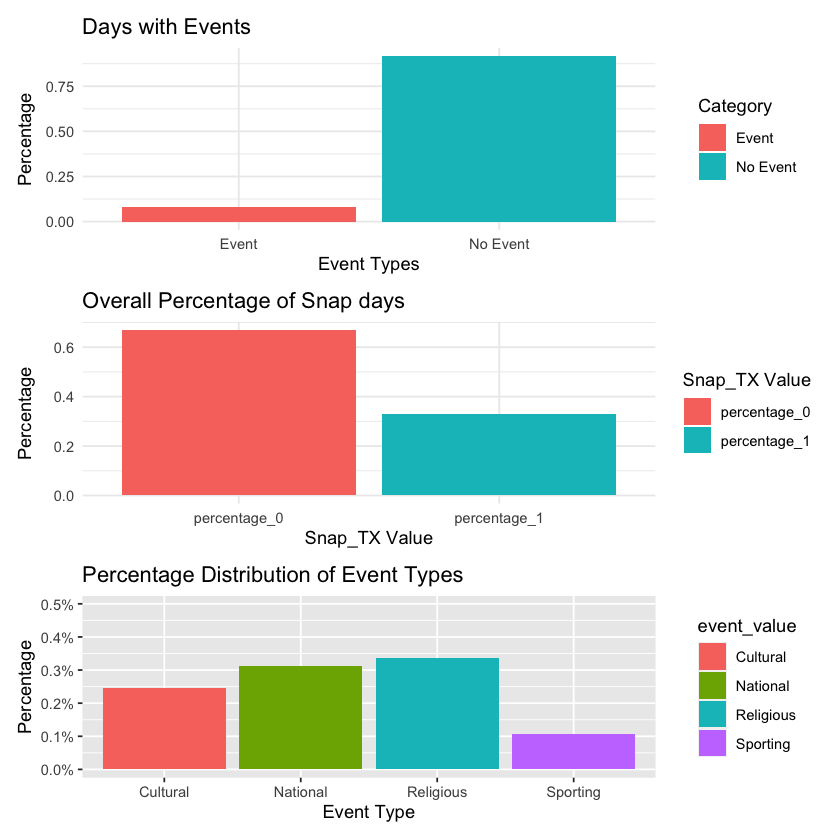

In [5]:

percentage_na <- calendar %>%
  filter(is.na(event_type_1) & is.na(event_type_2)) %>%
  nrow() / nrow(calendar) 

percentage_not_na <- 1 - percentage_na

plot_data_na <- data.frame(
  Category = c("No Event", "Event"),
  Percentage = c(percentage_na, percentage_not_na)
)

plot_na <- ggplot(plot_data_na, aes(x = Category, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity") +
  labs(title = "Days with Events",
       y = "Percentage",
       x = "Event Types") +
  theme_minimal()


summary_table <- calendar %>%
  summarize(percentage_0 = mean(snap_TX == 0, na.rm = TRUE),
            percentage_1 = mean(snap_TX == 1, na.rm = TRUE))

df_long <- summary_table %>%
  pivot_longer(cols = starts_with("percentage"), names_to = "Snap_TX Value", values_to = "Percentage")

plot_snap_tx <- ggplot(df_long, aes(x = `Snap_TX Value`, y = Percentage, fill = `Snap_TX Value`)) +
  geom_bar(stat = "identity") +
  labs(title = "Overall Percentage of Snap days",
       x = "Snap_TX Value",
       y = "Percentage") +
  theme_minimal()

plot_event_types <- calendar %>%
  filter(!is.na(event_type_1) | !is.na(event_type_2)) %>%
  gather(event_type, event_value, event_type_1, event_type_2) %>%
  filter(!is.na(event_value)) %>%
  group_by(event_value) %>%
  summarize(percentage = n() / nrow(.)) %>%
  ggplot(aes(x = event_value, y = percentage, fill = event_value)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = scales::percent_format(scale = 1), limits = c(0, 0.5)) +
  labs(title = "Percentage Distribution of Event Types",
       x = "Event Type",
       y = "Percentage")

combined_plot <- plot_na + plot_snap_tx + plot_event_types +
  plot_layout(ncol = 1)

print(combined_plot)


In [6]:
df_long

Snap_TX Value,Percentage
<chr>,<dbl>
percentage_0,0.6698832
percentage_1,0.3301168


In [7]:
plot_data_na

Category,Percentage
<chr>,<dbl>
No Event,0.91772473
Event,0.08227527


In [8]:
# Snap Days per month


snap_days <- calendar %>%
  group_by(year, month) %>%
  summarise(snap_TX_sum = sum(snap_TX)) %>%
  ungroup()


pivot_snap_days <- snap_days %>%
  pivot_wider(names_from = year, values_from = snap_TX_sum, names_prefix = "year_")


pivot_snap_days

`summarise()` has grouped output by 'year'. You can override using the `.groups`
argument.


month,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,10,10,10,10,10
2,10,10,10,10,10,10
3,10,10,10,10,10,10
4,10,10,10,10,10,10
5,10,10,10,10,10,10
6,10,10,10,10,10,10
7,10,10,10,10,10,NA
8,10,10,10,10,10,NA
9,10,10,10,10,10,NA


In [9]:
# Unique snap days

unique_snap_days <- calendar %>%
  filter(snap_TX == 1) %>%
  mutate(day = day(date)) %>%
  select(day) %>%
  distinct()

# Print the result
unique_snap_days


day
<int>
1
3
5
6
7
9
11
12
13


~~ Package calendR
Visit https://r-coder.com/ for R tutorials ~~



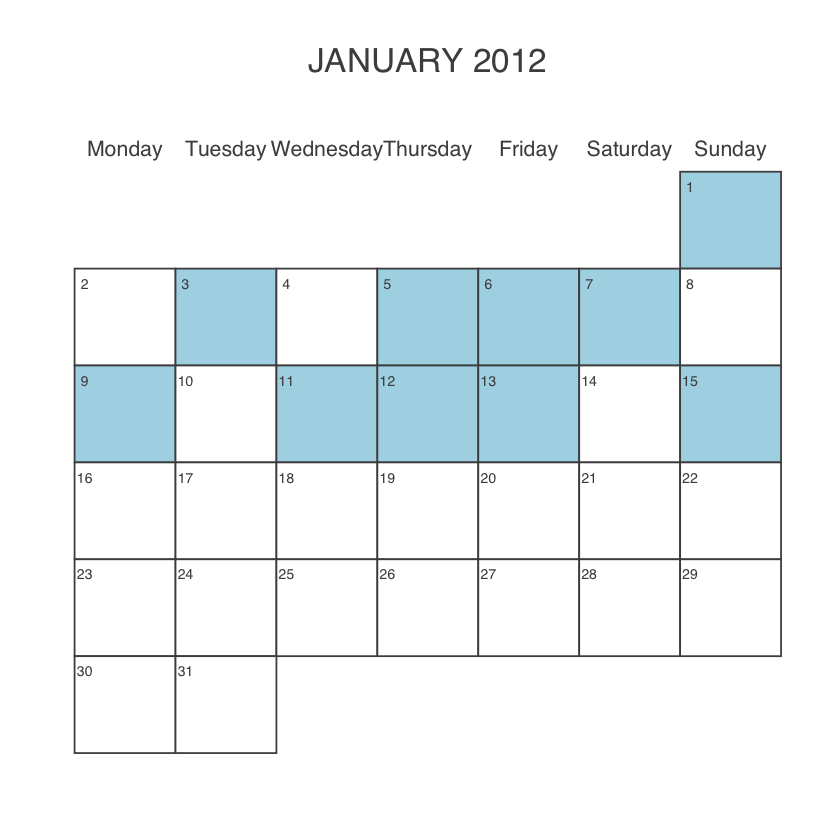

In [10]:
#install.packages("calendR")
library(calendR)

calendR(year = 2012,
        month = 1,
        start = "M",
        special.days = c(1,3,5,6,7,9,11,12,13,15),
        special.col = "lightblue",            
        low.col = "white") 

In [11]:
# ## Combine calendar with Sales
# foo <- sales_train_validation %>%
#   group_by(id) %>% 
#   summarise_at(vars(starts_with("d_")), sum) %>% 
#   extract_ts() %>% 
#   rename(cat_id = id) %>% 
#   left_join(calendar %>% select(date, event_type_1,event_type_2,snap_TX), by = c("date" = "date")) %>% 
#   filter(!str_detect(as.character(dates), "-12-25")) %>% # Remove Christmas where stores are closed
#   group_by(cat_id) %>% 
#   ungroup()

# sales_train <- sales_train_validation %>%
#   group_by(id) %>% 
#   summarise_at(vars(starts_with("d_")), sum) %>% 
#   rename(id = cat_id) %>% 
#   extract_ts() %>% 
#   rename(cat_id = id) %>% 
#   left_join(calendar %>% select(date, event_type_1), by = c("dates" = "date")) %>% 
#   filter(!str_detect(as.character(dates), "-12-25")) %>% 
#   group_by(cat_id) %>% 
#   mutate(loess = predict(loess(sales ~ as.integer(dates - min(dates)) + 1, span = 1/2, degree = 1)),
#          mean_sales = mean(sales)) %>% 
#   mutate(sales_rel = (sales - loess)/mean_sales) %>% 
#   mutate(is_event = !is.na(event_type_1)) %>% 
#   ungroup()

In [12]:
sales_train_validation_merged

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,⋯,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco_De_Mayo,event_name_2_Easter,event_name_2_Father_s_day,event_name_2_None,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_None,event_type_2_Religious
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-29,11101,Saturday,1,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-01-30,11101,Sunday,2,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-01-31,11101,Monday,3,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-01,11101,Tuesday,4,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-02,11101,Wednesday,5,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-03,11101,Thursday,6,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-04,11101,Friday,7,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-05,11102,Saturday,1,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,None,None,⋯,0,1,0,0,0,1,0,0,1,0


In [13]:


# Assuming your tibble is named 'foo'
avg <- sales_train_validation_merged %>%
  group_by(year = lubridate::year(date), 
           month = lubridate::month(date), 
           snap_TX) %>%
  summarise(avg_sales = mean(sales))

`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups`
argument.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


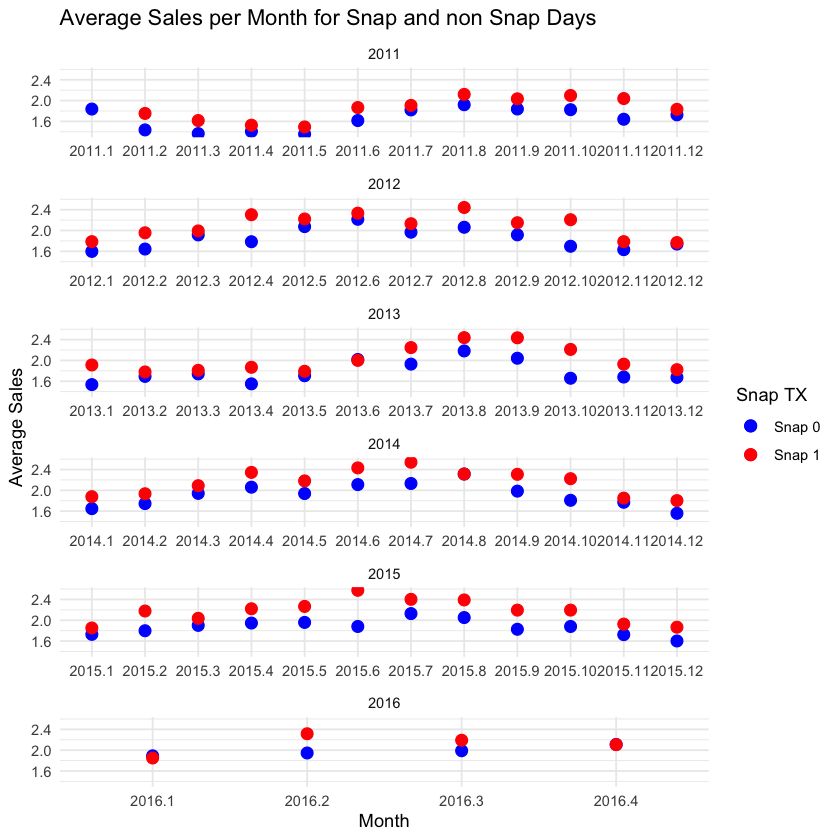

In [14]:


combined_avg <- avg %>%
  pivot_wider(names_from = snap_TX, values_from = avg_sales, names_prefix = "avg_sales_snap")


names(combined_avg) <- c("year", "month", "avg_sales_snap_0", "avg_sales_snap_1")


combined_avg %>%
  ggplot(aes(x = interaction(year, month, drop = TRUE))) +
  geom_point(aes(y = avg_sales_snap_0, color = "Snap 0"), size = 3) +
  geom_point(aes(y = avg_sales_snap_1, color = "Snap 1"), size = 3) +
  labs(title = "Average Sales per Month for Snap and non Snap Days",
       x = "Month",
       y = "Average Sales",
       color = "Snap TX") +
  scale_color_manual(values = c("Snap 0" = "blue", "Snap 1" = "red")) +
  theme_minimal() +
  facet_wrap(~ year, scales = "free_x", ncol = 1)  # Creates a separate graph for each year


In [15]:

result <- sales_train_validation_merged %>%
  group_by(snap_TX) %>%
  summarise(relative_sales = mean(sales, na.rm = TRUE))

result

snap_TX,relative_sales
<dbl>,<dbl>
0,1.824956
1,2.064589


In [16]:

combined_avg$percentage_difference <- ((combined_avg$avg_sales_snap_1 - combined_avg$avg_sales_snap_0) / combined_avg$avg_sales_snap_0) * 100


average_percentage_difference <- mean(combined_avg$percentage_difference, na.rm = TRUE)

cat("Average Percentage Difference:", average_percentage_difference, "%\n")

Average Percentage Difference: 13.34773 %


In [17]:
sales_train_validation_merged

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,⋯,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco_De_Mayo,event_name_2_Easter,event_name_2_Father_s_day,event_name_2_None,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_None,event_type_2_Religious
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-29,11101,Saturday,1,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-01-30,11101,Sunday,2,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-01-31,11101,Monday,3,1,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-01,11101,Tuesday,4,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-02,11101,Wednesday,5,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-03,11101,Thursday,6,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-04,11101,Friday,7,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-05,11102,Saturday,1,2,2011,None,None,None,None,⋯,0,0,0,0,0,1,0,0,1,0
2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,None,None,⋯,0,1,0,0,0,1,0,0,1,0


In [18]:


result <- sales_train_validation_merged %>%
  group_by(event_type_1, event_type_2, year) %>%
  summarise(avg_sales = mean(sales, na.rm = TRUE))

result_cal <- calendar %>%
  group_by(event_type_1, event_type_2) %>%
  summarise(sum_rows = n())



`summarise()` has grouped output by 'event_type_1', 'event_type_2'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'event_type_1'. You can override using the `.groups`
argument.


Loading required package: viridisLite



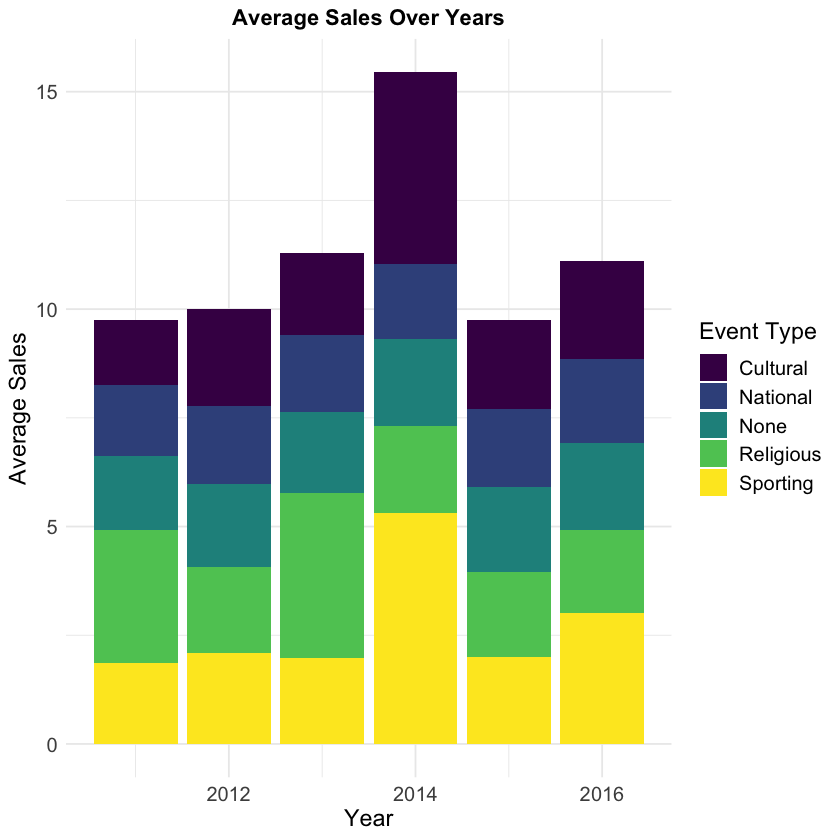

In [19]:
#install.packages("viridis")


library(viridis)


ggplot(result, aes(x = year, y = avg_sales, fill = event_type_1)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Sales Over Years",
       x = "Year",
       y = "Average Sales",
       fill = "Event Type") +
  scale_fill_viridis_d() +  # Use the viridis color palette
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )


## Analysis of subsequent days

In [56]:

filtered_data <- calendar %>%
  filter(!is.na(event_type_1))



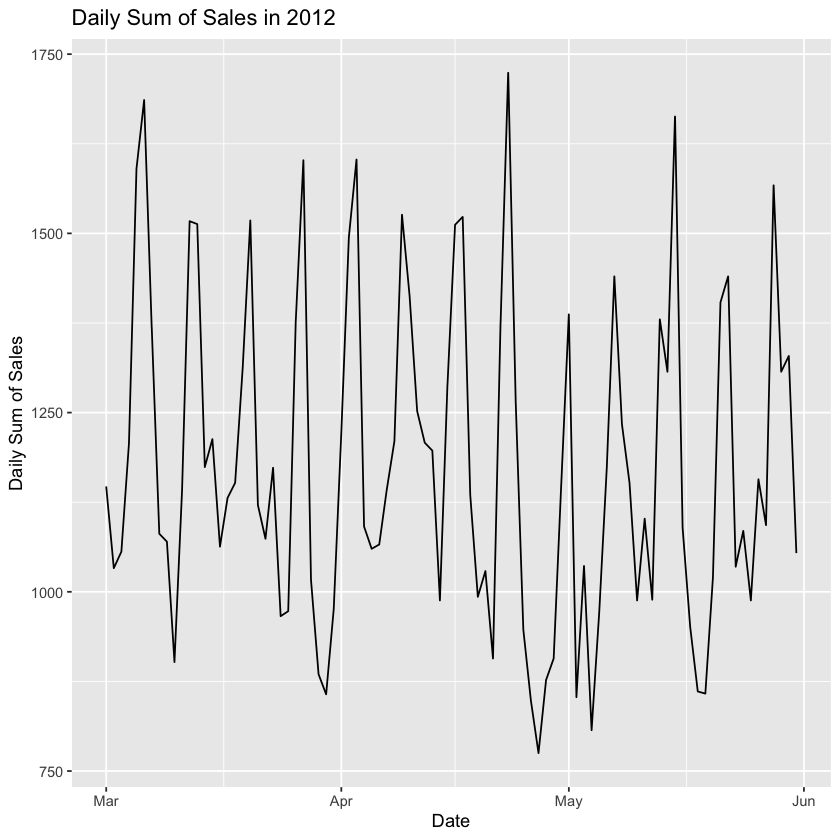

In [67]:

your_data_2012 <- sales_train_validation_merged %>%
  filter(year(date) == 2011,( month(date) == 3 | month(date) == 4 | month(date) == 5))

# Group by date and calculate the daily sum of sales
daily_sales_2012 <- your_data_2012 %>%
  group_by(date) %>%
  summarise(daily_sum_sales = sum(sales))

# Plot the daily sum of sales for 2012
ggplot(daily_sales_2012, aes(x = date, y = daily_sum_sales)) +
  geom_line() +
  labs(title = "Daily Sum of Sales in 2012",
       x = "Date",
       y = "Daily Sum of Sales")

In [68]:
filtered_data |> filter((month == 3 | month == 4 | month == 5) & year == 2011)

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
3/9/2011,11106,Wednesday,5,3,2011,LentStart,Religious,NA,NA,1
3/16/2011,11107,Wednesday,5,3,2011,LentWeek2,Religious,NA,NA,0
3/17/2011,11107,Thursday,6,3,2011,StPatricksDay,Cultural,NA,NA,0
3/20/2011,11108,Sunday,2,3,2011,Purim End,Religious,NA,NA,0
4/24/2011,11113,Sunday,2,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0
4/26/2011,11113,Tuesday,4,4,2011,Pesach End,Religious,NA,NA,0
5/5/2011,11114,Thursday,6,5,2011,Cinco De Mayo,Cultural,NA,NA,1
5/8/2011,11115,Sunday,2,5,2011,Mother's day,Cultural,NA,NA,0
5/30/2011,11118,Monday,3,5,2011,MemorialDay,National,NA,NA,0


In [69]:
filtered_data |> head()

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2/6/2011,11102,Sunday,2,2,2011,SuperBowl,Sporting,NA,NA,1
2/14/2011,11103,Monday,3,2,2011,ValentinesDay,Cultural,NA,NA,0
2/21/2011,11104,Monday,3,2,2011,PresidentsDay,National,NA,NA,0
3/9/2011,11106,Wednesday,5,3,2011,LentStart,Religious,NA,NA,1
3/16/2011,11107,Wednesday,5,3,2011,LentWeek2,Religious,NA,NA,0
3/17/2011,11107,Thursday,6,3,2011,StPatricksDay,Cultural,NA,NA,0


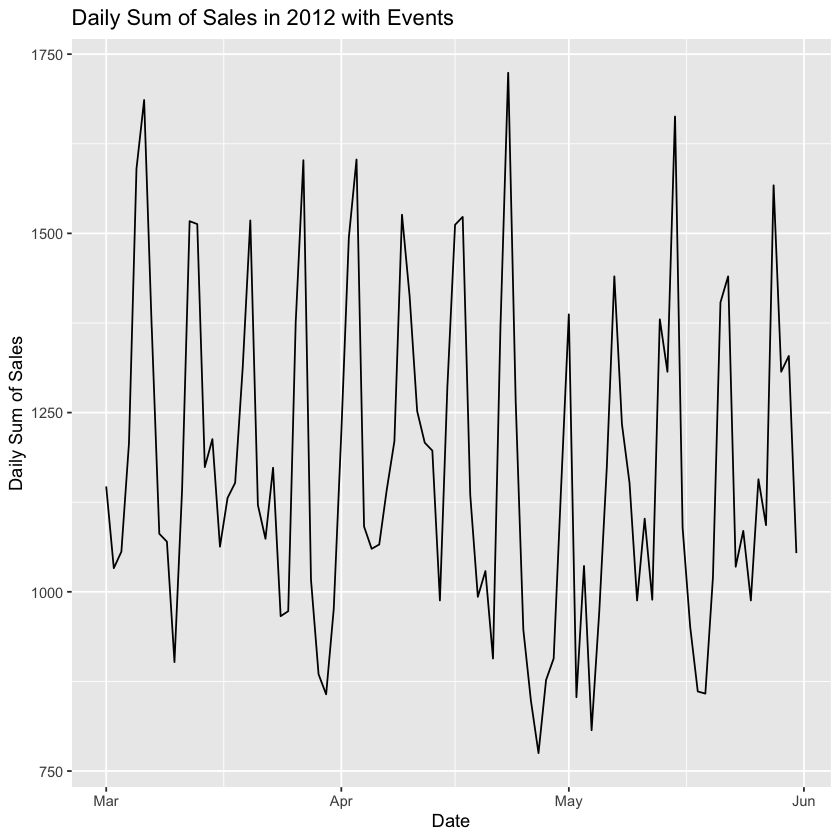

In [72]:
# Merge or join the data
merged_data <- merge(daily_sales_2012, filtered_data, by.x = "date", by.y = "date", all.x = TRUE)

# Plot the daily sum of sales for 2012 with events
ggplot(merged_data, aes(x = date, y = daily_sum_sales)) +
  geom_line() +
  geom_point(data = merged_data[!is.na(merged_data$event_name_1), ], aes(x = date, y = daily_sum_sales), color = "red", size = 3) +
  labs(title = "Daily Sum of Sales in 2012 with Events",
       x = "Date",
       y = "Daily Sum of Sales")